# Libaries Importing

In [1]:
import pandas as pd
import yfinance as yf  
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [25]:
def fetch_OHLCV(tickers, start_date, end_date):
  # Empty list to store the
  data_ls = []

  # Looping over the required tickers
  for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date).droplevel(axis=1,level=1).reset_index()
    data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    data['Ticker'] = ticker
    data_ls.append(data)

  # Creation of the larger dataset
  data_final = pd.concat(data_ls)
  return data_final

In [26]:
# Fetch data function calling
tickers = ['TITAN.NS', 'HDFCBANK.NS', 'ITC.NS', 'SUNPHARMA.NS', 'TECHM.NS']
start='2010-01-01'
end='2025-11-26'

In [27]:
benchmark_symbol = '^NSEI'

df_benchmark = fetch_OHLCV([benchmark_symbol], start, end)
df_benchmark['Returns'] = df_benchmark['Close'].pct_change()
df_benchmark.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


### Preprocessng Data

In [ ]:
def inspect_data(df, viz_dir='preprocessing_viz'):
    """Step 1: Inspect the Data - Summary stats and initial visualizations."""
    os.makedirs(viz_dir, exist_ok=True)
    
    # Print summary stats
    print(f"Shape: {df.shape}")
    print(df.info())
    print(df.describe())
    
    # Viz 1: Timeseries plot of Close prices by Ticker
    fig, ax = plt.subplots(figsize=(12, 6))
    for ticker in df['Ticker'].unique():
        ticker_df = df[df['Ticker'] == ticker]
        ax.plot(ticker_df['Date'], ticker_df['Returns'], label=ticker)
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.set_title('Timeseries of Returns by Ticker')
    ax.legend()
    timeseries_plot = os.path.join(viz_dir, 'timeseries_Returns.png')
    plt.savefig(timeseries_plot)
    plt.close(fig)
    
    # Viz 2: Histogram of Close prices by Ticker
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Returns', hue='Ticker', element='step', bins=20)
    plt.title('Distribution of Close Prices (Inspection)')
    plt.xlabel('Close Price')
    plt.ylabel('Frequency')
    inspect_hist = os.path.join(viz_dir, 'inspect_close_hist.png')
    plt.savefig(inspect_hist)
    plt.close()
    
    return df, [timeseries_plot, inspect_hist]

def handle_missing(df, viz_dir='preprocessing_viz'):
    """Step 2: Handle Missing Values - Visualize and forward-fill."""
    print("Missing before:", df.isnull().sum())
    

    
    # Process: Forward-fill per ticker
    df = df.sort_values(['Ticker', 'Date']).copy()
    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df.groupby('Ticker')[['Open', 'High', 'Low', 'Close', 'Volume']].ffill()
    df = df.dropna()
    
    print("Missing after:", df.isnull().sum())
    
    # # Viz: Missing bar after
    # plt.figure(figsize=(10, 6))
    # msno.bar(df, color='skyblue')
    # plt.title('Missing Values Bar (After)')
    # missing_bar = os.path.join(viz_dir, 'missing_bar_after.png')
    # plt.savefig(missing_bar)
    # plt.close()
    
    return df

def remove_duplicates(df, viz_dir='preprocessing_viz'):
    """Step 3: Remove Duplicates - Count and drop."""
    dups_before = df.duplicated(subset=['Date', 'Ticker']).sum()
    print(f"Duplicates before: {dups_before}")
    
    # # Viz: Bar for duplicates
    # plt.figure(figsize=(6, 4))
    # plt.bar(['Duplicates'], [dups_before])
    # plt.title('Duplicate Count (Before Removal)')
    # dups_bar = os.path.join(viz_dir, 'duplicates_bar.png')
    # plt.savefig(dups_bar)
    # plt.close()
    
    df = df.drop_duplicates(subset=['Date', 'Ticker'], keep='first')
    print(f"Duplicates after: {df.duplicated(subset=['Date', 'Ticker']).sum()}")
    
    return df



# Main chaining function (optional: to run all steps sequentially)
def run_preprocessing_pipeline(tickers, start_date, end_date, viz_dir='preprocessing_viz'):
    """Chains all separate functions; returns full results."""
    os.makedirs(viz_dir, exist_ok=True)
    df = fetch_OHLCV(tickers, start_date, end_date)
    df['Returns'] = df.groupby('Ticker')['Close'].pct_change()
    df.dropna(inplace=True)
    all_viz_files = []
    
    # Run each step
    df, viz1 = inspect_data(df, viz_dir)
    all_viz_files.extend(viz1)
    
    df = handle_missing(df, viz_dir)
    # all_viz_files.extend(viz2)
    
    full_df = remove_duplicates(df, viz_dir)
    # all_viz_files.extend(viz3)
    

    
    return {
        'preprocessed_df': full_df,
        'all_viz_files': [f for f in all_viz_files if os.path.exists(f)]
    }

# Usage Example:
results = run_preprocessing_pipeline(tickers, start, end)
ohlcv_data = results['preprocessed_df']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape: (19620, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 19620 entries, 1 to 3924
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     19620 non-null  datetime64[ns]
 1   Close    19620 non-null  float64       
 2   High     19620 non-null  float64       
 3   Low      19620 non-null  float64       
 4   Open     19620 non-null  float64       
 5   Volume   19620 non-null  int64         
 6   Ticker   19620 non-null  object        
 7   Returns  19620 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.3+ MB
None
                                Date         Close          High  \
count                          19620  19620.000000  19620.000000   
mean   2017-12-15 07:44:35.229357824    629.324855    636.636535   
min              2010-01-05 00:00:00     49.024235     51.546693   
25%              2013-12-19 18:00:00    192.068600    194.721613   
50% 

# Portfolio Optimization

In [29]:

def portfolio_performance(weights, mean_returns, cov_matrix):     
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return returns, std

# # Calculate mean returns and covariance matrix
returns = ohlcv_data.pivot(index='Date', columns='Ticker', values='Returns').dropna()
mu = returns.mean()
S = returns.cov()

# let'ssuppose we had a portfolio with equal weights on all the above tickers
equal_weights = np.array([1/len(tickers)] * len(tickers))
print("Equal Weights:", equal_weights)

eql_wt_returns, eql_wt_std = portfolio_performance(equal_weights, mu, S)
print("Equal Weights Portfolio - Returns:", eql_wt_returns)
print("Equal Weights Portfolio - Std Dev:", eql_wt_std)

sharpe_ratio_optimized = (eql_wt_returns - 0.00) / eql_wt_std
print("Equal Weights Portfolio - Sharpe Ratio:", sharpe_ratio_optimized)


Equal Weights: [0.2 0.2 0.2 0.2 0.2]
Equal Weights Portfolio - Returns: 0.209675295539413
Equal Weights Portfolio - Std Dev: 0.16712113055582706
Equal Weights Portfolio - Sharpe Ratio: 1.254630667241511


In [31]:
def monte_carlo_simulation(ohlcv_data,num_iterations, num_assets):
          
    returns = ohlcv_data.pivot(index='Date', columns='Ticker', values='Returns').dropna()
    mu = returns.mean()
    S = returns.cov()
    num_assets = len(tickers)

      
    returns_ls = []
    std_ls = []
    sharpe_ls = []
    weights_record = []
    # Simulation
    
    for i in range(num_iterations):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        returns, std = portfolio_performance(weights, mu, S)
        sharpe_ratio = (returns - 0.00) / std
        weights_record.append(weights)
        returns_ls.append(returns)
        std_ls.append(std)
        sharpe_ls.append(sharpe_ratio)

    # Monte Carlo output DataFrame
    monte_carlo_output = pd.DataFrame({
        'Weights': weights_record,
        'Returns': returns_ls,
        'Volatility': std_ls,
        'Sharpe Ratio': sharpe_ls
    })

    best_row = monte_carlo_output.loc[monte_carlo_output['Sharpe Ratio'].idxmax()]
    monte_df = pd.DataFrame(best_row).reset_index()
    monte_df.columns = ['Metric', 'Value']
    optimized_weights = monte_df['Value'][0]

    # Create directory if missing
    viz_dir = "viz_dir"
    os.makedirs(viz_dir, exist_ok=True)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(
        monte_carlo_output['Volatility'],
        monte_carlo_output['Returns'],
        c=monte_carlo_output['Sharpe Ratio'],
        cmap='viridis'
    )

    # Highlight optimal Sharpe point
    ax.scatter(
        best_row['Volatility'],
        best_row['Returns'],
        s=200,
        marker='*'
    )

    ax.set_title('Monte Carlo Portfolio Optimization')

    # Save figure
    fig_path = os.path.join(viz_dir, "monte_carlo_plot.png")
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')

    plt.show()

    return monte_df, optimized_weights


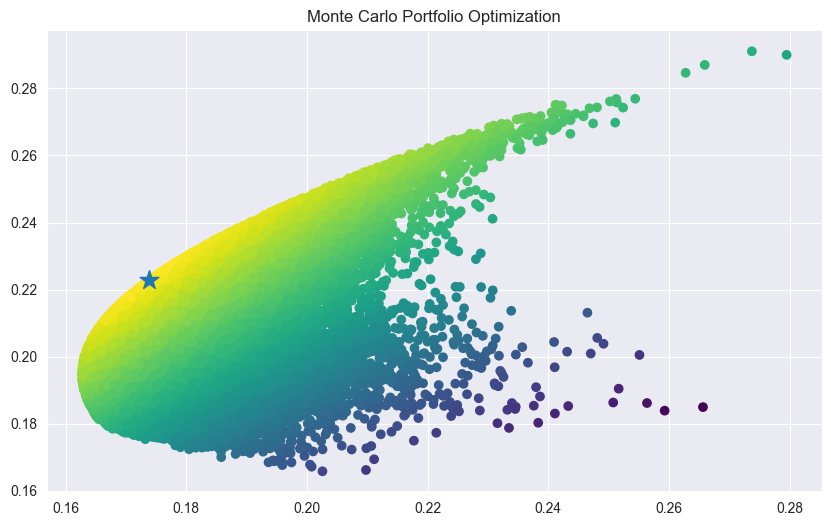

In [32]:
monte_carlo_results, optimized_weights = monte_carlo_simulation(ohlcv_data,
    num_iterations=100000,
    num_assets=len(tickers)
)

In [519]:
df_benchmark_pivot = df_benchmark.pivot(index='Date', columns='Ticker', values='Close').dropna().reset_index()
df_benchmark_pivot['benchamark_returns'] = df_benchmark_pivot[benchmark_symbol].pct_change()
df_benchmark_pivot.dropna(inplace=True)
df_benchmark_pivot.columns = ['Date', 'Benchmark_Close', 'Benchmark_Returns']

In [521]:
def plot_optimized_portfolio(ohlcv_data, tickers, optimized_weights, initial_investment=1000000):
    """
    Computes and plots the equity curve for an optimized portfolio based on given weights."""
    save_dir = "viz_dir/Equity_Curve"
    os.makedirs(save_dir, exist_ok=True)

    # prepare dataframes (drop rows with NaNs)
    close_df = ohlcv_data.pivot(index='Date', columns='Ticker', values='Close').dropna().reset_index()
    return_df = ohlcv_data.pivot(index='Date', columns='Ticker', values='Returns').dropna().reset_index()

    # ensure date column is datetime and sorted ascending
    close_df['Date'] = pd.to_datetime(close_df['Date'])
    close_df = close_df.sort_values('Date').reset_index(drop=True)
    return_df['Date'] = pd.to_datetime(return_df['Date'])
    return_df = return_df.sort_values('Date').reset_index(drop=True)

    # validate optimized_weights
    optimized_weights = np.asarray(optimized_weights, dtype=float)
    if optimized_weights.ndim != 1 or optimized_weights.size != len(tickers):
        raise ValueError("optimized_weights must be 1D and match number of tickers")

    # get price matrix for selected tickers (rows = dates, cols = tickers)
    price_matrix = close_df[tickers].values.astype(float)  # shape (T, N)

    # reference buy prices: use first available row (earliest date)
    initial_stock_prices = price_matrix[0, :]  # shape (N,)

    # compute cash allocation and integer share counts
    initial_cash_weights = initial_investment * optimized_weights
    num_shares = np.floor(initial_cash_weights / initial_stock_prices).astype(int)

    # compute daily portfolio value (INR)
    # multiply each column (ticker) by corresponding share count and sum across tickers
    portfolio_values = (price_matrix * num_shares).sum(axis=1)  # shape (T,)
    close_df['Portfolio Value'] = portfolio_values

    # optional: compute portfolio returns (simple pct change) and cumulative returns
    portfolio_returns = pd.Series(portfolio_values, index=close_df['Date']).pct_change().fillna(0)
    return_df['Portfolio Returns'] = portfolio_returns.values
    cumulative_return = (1 + portfolio_returns).cumprod() - 1  # cumulative return series
    return_df['Cumulative Return'] = cumulative_return.values

    # plotting
    sns.set_style('darkgrid')
    plt.figure(figsize=(20, 5))
    plt.plot(close_df['Date'], portfolio_values, marker=None)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (INR)')
    plt.title('Equity Curve of Optimized Portfolio')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'equity_curve.png'), dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()

    # compute summary
    allocated_cash = (num_shares * initial_stock_prices)
    leftover_cash = initial_investment - allocated_cash.sum()
    
    # Print summary
    print("Initial prices:", dict(zip(tickers, initial_stock_prices)))
    print("Shares purchased:", dict(zip(tickers, num_shares)))
    print(f"Allocated cash: {allocated_cash.sum():,.0f} INR, Leftover cash: {leftover_cash:,.0f} INR")
    
    # Return summary dict for further use
    summary = {
        'initial_prices': dict(zip(tickers, initial_stock_prices)),
        'shares_purchased': dict(zip(tickers, num_shares)),
        'allocated_cash': allocated_cash.sum(),
        'leftover_cash': leftover_cash
    }
    return summary, close_df, return_df

In [522]:
summary, close_df,return_df = plot_optimized_portfolio(ohlcv_data, tickers, optimized_weights, initial_investment=1000000)

Initial prices: {'HDFCBANK.NS': np.float64(75.01045227050781), 'ITC.NS': np.float64(54.06913757324219), 'SUNPHARMA.NS': np.float64(139.2169647216797), 'TECHM.NS': np.float64(179.57937622070312), 'TITAN.NS': np.float64(66.9311294555664)}
Shares purchased: {'HDFCBANK.NS': np.int64(3259), 'ITC.NS': np.int64(2524), 'SUNPHARMA.NS': np.int64(1630), 'TECHM.NS': np.int64(619), 'TITAN.NS': np.int64(4194)}
Allocated cash: 999,722 INR, Leftover cash: 278 INR


# Final Data Creation

In [518]:
final_df = return_df.merge(close_df, on='Date', suffixes=('_Return', '_Close'))
final_df = final_df.merge(df_benchmark_pivot, on='Date', how='left')
final_df.dropna(inplace=True)
final_df.columns = ['Date', 'HDFCBANK_Returns', 'ITC_Returns', 'SUNPHARMA_Returns',
       'TECHM_Returns', 'TITAN_Returns', 'Portfolio_Returns',
       'Cumulative Returns', 'HDFCBANK_Close', 'ITC_Close',
       'SUNPHARMA_Close', 'TECHM_Close', 'TITAN_Close',
       'Portfolio_Close', 'Benchmark_Close', 'Benchmark_Returns']
final_df

,Date,HDFCBANK_Returns,ITC_Returns,SUNPHARMA_Returns,TECHM_Returns,TITAN_Returns,Portfolio_Returns,Cumulative Returns,HDFCBANK_Close,ITC_Close,SUNPHARMA_Close,TECHM_Close,TITAN_Close,Portfolio_Close,Benchmark_Close,Benchmark_Returns
1,2010-01-06,0.000674,0.002342,0.012978,0.004922,0.016096,0.008497,0.008497,75.060974,54.195786,141.023712,180.463318,68.008453,1.008217e+06,5281.799805,0.000739
2,2010-01-07,0.002605,-0.003116,-0.015228,-0.021994,0.024864,0.001335,0.009843,75.256477,54.026917,138.876236,176.494232,69.699448,1.009562e+06,5263.100098,-0.003540
3,2010-01-08,0.001314,0.002149,0.016851,0.026318,-0.009234,0.004562,0.014450,75.355347,54.143013,141.216446,181.139267,69.055809,1.014168e+06,5244.750000,-0.003487
4,2010-01-11,-0.004023,0.000390,-0.000159,-0.006315,-0.008084,-0.003965,0.010428,75.052170,54.164146,141.194061,179.995316,68.497536,1.010147e+06,5249.399902,0.000887
5,2010-01-12,-0.007581,-0.025526,-0.001842,0.006789,-0.002560,-0.005689,0.004680,74.483177,52.781532,140.933975,181.217285,68.322205,1.004400e+06,5210.399902,-0.007429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,2025-11-19,0.002166,-0.005667,0.014385,0.008369,0.013895,0.011364,23.557877,994.599976,403.549988,1784.099976,1433.900024,3933.100098,2.455105e+07,26052.650391,0.005504
3920,2025-11-20,0.014327,0.004708,-0.003755,0.015412,-0.007806,-0.003045,23.483095,1008.849976,405.450012,1777.400024,1456.000000,3902.399902,2.447629e+07,26192.150391,0.005355
3921,2025-11-21,-0.010705,0.005919,0.001294,0.003777,0.000461,-0.000590,23.468654,998.049988,407.850006,1779.699951,1461.500000,3904.199951,2.446185e+07,26068.150391,-0.004734
3922,2025-11-24,0.001102,-0.010543,0.000618,0.022716,-0.007658,-0.004510,23.358299,999.150024,403.549988,1780.800049,1494.699951,3874.300049,2.435153e+07,25959.500000,-0.004168


# Required Metrics

we started out with Allocated cash: 999,916 INR, Leftover cash: 84 INR
now let us check for import metrics, that can help us understand, individual stocks, Portfolio and Benchmark performance over time.

### Performance Metrics

In [178]:

assets = ['HDFCBANK', 'ITC', 'SUNPHARMA','TECHM', 'TITAN']
benchmark_col = ['Benchmark']
portfolio_col = ['Portfolio']



In [ ]:
def calculate_performance_ratios(df, asset_list, benchmark_col = 'Benchmark' ,risk_free_rate=0.00):
    """Calculate performance ratios for each ticker."""

    results = {}
    results_benchmark = {}
    # Benchmark stats
    benchmark_returns = df[f'{benchmark_col[0]}_Returns']
    benchmark_mean = benchmark_returns.mean()
    benchmark_std = benchmark_returns.std()
    downside_benchmark_std = np.sqrt(np.mean(np.minimum(0, benchmark_returns)**2))

    # Sharpe and Sortino for Benchmark
    sharpe_ratio_benchmark = (benchmark_mean - risk_free_rate/252) / benchmark_std
    sortino_ratio_benchmark = (benchmark_mean - risk_free_rate/252) / downside_benchmark_std  

    results_benchmark['Benchmark'] = {
        'Annualised Sharpe Ratio': sharpe_ratio_benchmark* np.sqrt(252),
        'Annualised Sortino Ratio': sortino_ratio_benchmark* np.sqrt(252)
    }

    
    if asset_list != benchmark_col:
      for ticker in asset_list:
              
          returns = df[f'{ticker}_Returns']
          mean_return = returns.mean()
          std_return = returns.std()
          downside_std = np.sqrt(np.mean(np.minimum(0, returns)**2))
          
        # Sharpe Ratio
          sharpe_ratio = (mean_return - risk_free_rate/252) / std_return

        # Sortino Ratio
          sortino_ratio = (mean_return - risk_free_rate/252) / downside_std

        # Information Ratio
          information_ratio = (mean_return - benchmark_mean) / np.std(returns - benchmark_returns)
          
          results[ticker] = {
              'Annualised Sharpe Ratio': sharpe_ratio * np.sqrt(252),
              'Annualised Sortino Ratio': sortino_ratio* np.sqrt(252),
              'Information Ratio': information_ratio
          }

      return pd.DataFrame(results).T 
    
    else:
          return pd.DataFrame(results_benchmark).T    
    
    

In [182]:
asset_performance_df = calculate_performance_ratios(final_df, assets, benchmark_col=benchmark_col)
portfolio_performance_df = calculate_performance_ratios(final_df, portfolio_col, benchmark_col=benchmark_col)
benchmark_performance_df = calculate_performance_ratios(final_df, benchmark_col,benchmark_col=benchmark_col)


In [387]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # For value labels

def performance_plotting(asset_df, portfolio_df, benchmark_df,save_dir='viz_dir/performance_plots'):
    # Set a beautiful seaborn style
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", 3)  # Professional palette: [blue-ish, green-ish, red-ish]
    
    # Create viz_dir if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    def plot_and_save(title, ylabel, y_col, filename, dataframes, labels):
        plt.figure(figsize=(12, 7))  # Slightly larger for beauty
        
        # Plot bars with colors and transparency
        ax = sns.barplot(x=dataframes[0].index, y=y_col, data=dataframes[0], 
                         color=colors[0], alpha=0.8, label=labels[0])
        sns.barplot(x=dataframes[1].index, y=y_col, data=dataframes[1], 
                    color=colors[1], alpha=0.8, label=labels[1])
        if len(dataframes) > 2:  # Include benchmark if provided
            sns.barplot(x=dataframes[2].index, y=y_col, data=dataframes[2], 
                        color=colors[2], alpha=0.8, label=labels[2])
        
        # # Add value labels on bars
        # for i, df in enumerate(dataframes):
        #     for j, val in enumerate(df[y_col]):
        #         ax.text(j + (i-1)*0.2, val + (0.01 * np.sign(val) if val != 0 else 0.01), 
        #                 f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.ylabel(ylabel, fontsize=12, fontweight='bold')
        plt.xlabel('Assets/Portfolio/Benchmark', fontsize=12)
        # plt.xticks(rotation=45, ha='right')
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, fancybox=True, shadow=True)
        plt.tight_layout()
        
        # Save with error handling
        try:
            plt.savefig(f'{save_dir}/{filename}', dpi=300, bbox_inches='tight', facecolor='white')
            print(f"{filename} saved successfully.")
        except Exception as e:
            print(f"Error saving {filename}: {e}")
            
        # plt.show()
        plt.close()
    
    # Sharpe plot
    plot_and_save('Annualised Sharpe Ratios Comparison', 'Annualised Sharpe Ratio', 
                  'Annualised Sharpe Ratio', 'annualised_sharpe_ratios_comparison.png',
                  [asset_df, portfolio_df, benchmark_df], ['Assets', 'Portfolio', 'Benchmark'])
    
    # Sortino plot
    plot_and_save('Annualised Sortino Ratios Comparison', 'Annualised Sortino Ratio', 
                  'Annualised Sortino Ratio', 'annualised_sortino_ratios_comparison.png',
                  [asset_df, portfolio_df, benchmark_df], ['Assets', 'Portfolio', 'Benchmark'])
    
    # Information Ratio plot 
    plot_and_save('Information Ratios Comparison', 'Information Ratio', 
                  'Information Ratio', 'information_ratios_comparison.png',
                  [asset_df, portfolio_df], ['Assets', 'Portfolio'])

# Call the function (assuming your DataFrames are defined)
performance_plotting(asset_performance_df, portfolio_performance_df, benchmark_performance_df)

annualised_sharpe_ratios_comparison.png saved successfully.
annualised_sortino_ratios_comparison.png saved successfully.
information_ratios_comparison.png saved successfully.


### Drawdown Metrics

In [243]:
def drawdown_analysis(df, asset_list):
    """Calculate drawdown metrics for the portfolio."""  
    results = {}
    for ticker in asset_list:
        prices = df[f'{ticker}_Close']
        cumulative_max = prices.cummax()
        drawdowns = (prices - cumulative_max) / cumulative_max
        max_drawdown = drawdowns.min()

        
        results[ticker] = {
            'Max Drawdown': max_drawdown
        }

    return pd.DataFrame(results).T

In [246]:
asset_drawdowns_df = drawdown_analysis(final_df, assets)
portfolio_drawdowns_df = drawdown_analysis(final_df, portfolio_col)
benchmark_drawdowns_df = drawdown_analysis(final_df, benchmark_col)


In [389]:

def drawdowns_plotting(asset_drawdowns_df, portfolio_drawdowns_df, benchmark_drawdowns_df, save_path='viz_dir/drawdown_analysis_plots/drawdowns_comparison.png'):
    
    """Plot drawdowns for assets, portfolio, and benchmark in a single figure with subplots."""
    # Set a beautiful seaborn style (consistent with previous plots)
    sns.set_style("whitegrid")
    
    # Create save directory if it doesn't exist
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Create a single figure with subplots for side-by-side comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Share y-axis for consistency
    
    # Plot each DataFrame on its subplot
    asset_drawdowns_df.plot(kind='bar', ax=axes[0], color='blue', alpha=0.8, legend=False)
    axes[0].set_title('Asset Drawdowns', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    portfolio_drawdowns_df.plot(kind='bar', ax=axes[1], color='green', alpha=0.8, legend=False)
    axes[1].set_title('Portfolio Drawdowns', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    benchmark_drawdowns_df.plot(kind='bar', ax=axes[2], color='red', alpha=0.8, legend=False)
    axes[2].set_title('Benchmark Drawdowns', fontsize=14, fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    
    # Common styling
    for ax in axes:
        ax.set_ylabel('Drawdown Value', fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle('Drawdowns Comparison Across Assets, Portfolio, and Benchmark', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    # plt.show()
    
    # Optional: Save the combined plot
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Drawdowns plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
        plt.close()

# Example call (assuming your DataFrames are defined)
drawdowns_plotting(asset_drawdowns_df, portfolio_drawdowns_df, benchmark_drawdowns_df)

Drawdowns plot saved to viz_dir/drawdown_analysis_plots/drawdowns_comparison.png


### Returns

In [250]:
# lets calculate return metrics for benchmark, assets and portfolio
def return_metrics(df, asset_list, benchmark_col = 'Benchmark' ):
          
    df.sort_values('Date', inplace=True)
    results = {}
    results_benchmark = {}

    def calculate_cagr(returns_series, periods_per_year):
        if len(returns_series) == 0:
            return np.nan
        cumulative_return = (1 + returns_series).prod() - 1
        n_years = len(returns_series) / periods_per_year
        if n_years == 0:
            return np.nan
        return (1 + cumulative_return) ** (1 / n_years) - 1
    
      # Benchmark stats
    benchmark_returns = df[f'{benchmark_col[0]}_Returns']
    results_benchmark['Benchmark'] = {
            '1D Return': benchmark_returns.tail(1).values[0],
            '5D Return': (benchmark_returns.tail(5).values[0]/benchmark_returns.tail(1).values[0])-1,
            '1M Return': (benchmark_returns.tail(21).values[0]/benchmark_returns.tail(1).values[0])-1,
            '3M Return': (benchmark_returns.tail(63).values[0]/benchmark_returns.tail(1).values[0])-1,
            '6M Return': (benchmark_returns.tail(126).values[0]/benchmark_returns.tail(1).values[0])-1,
            '1Y CAGR': calculate_cagr(benchmark_returns.iloc[-252:], 252),
            '3Y CAGR': calculate_cagr(benchmark_returns.iloc[-756:], 252),
            '5Y CAGR': calculate_cagr(benchmark_returns.iloc[-1260:], 252)
    }

    if asset_list != benchmark_col:
      for ticker in asset_list:
              
          returns = df[f'{ticker}_Returns']
          
          results[ticker] = {
              '1D Return': returns.tail(1).values[0],
              '5D Return': (returns.tail(5).values[0]/benchmark_returns.tail(1).values[0])-1,
              '1M Return': (returns.tail(21).values[0]/benchmark_returns.tail(1).values[0])-1,
              '3M Return': (returns.tail(63).values[0]/benchmark_returns.tail(1).values[0])-1,
              '6M Return': (returns.tail(126).values[0]/benchmark_returns.tail(1).values[0])-1,
              '1Y CAGR': calculate_cagr(returns.iloc[-252:], 252),
              '3Y CAGR': calculate_cagr(returns.iloc[-756:], 252),
              '5Y CAGR': calculate_cagr(returns.iloc[-1260:], 252)      
              }
      return pd.DataFrame(results).T
    
    else:
       return pd.DataFrame(results_benchmark).T

In [251]:
assets_returns_metrics = return_metrics(final_df, assets, benchmark_col=benchmark_col)
portfolio_returns_metrics = return_metrics(final_df, portfolio_col, benchmark_col=benchmark_col)
benchmark_returns_metrics = return_metrics(final_df, benchmark_col,benchmark_col=benchmark_col)

In [391]:
def returns_metrics_plotting(assets_returns_metrics, portfolio_returns_metrics, benchmark_returns_metrics, 
                             save_path='viz_dir/returns_metrics_plots/returns_metrics_comparison.png'):
    
    """Plot return metrics for assets, portfolio, and benchmark in a single figure with subplots."""
    # Set a beautiful seaborn style (consistent with previous plots)
    sns.set_style("whitegrid")
    
    # Create save directory if it doesn't exist
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Use consistent figure size across subplots for better comparison
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)  # Share y-axis for consistency
    
    # Plot each DataFrame on its subplot
    assets_returns_metrics.plot(kind='bar', ax=axes[0], alpha=0.8, legend=True)
    axes[0].set_title('Assets Return Metrics Comparison', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    portfolio_returns_metrics.plot(kind='bar', ax=axes[1], alpha=0.8, legend=True)
    axes[1].set_title('Portfolio Return Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    benchmark_returns_metrics.plot(kind='bar', ax=axes[2], alpha=0.8, legend=True)
    axes[2].set_title('Benchmark Return Metrics Comparison', fontsize=14, fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    
    # Common styling
    for ax in axes:
        ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle('Return Metrics Comparison Across Assets, Portfolio, and Benchmark', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Optional: Save the combined plot
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Returns metrics plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
        # plt.show()
        plt.close()

returns_metrics_plotting(assets_returns_metrics, portfolio_returns_metrics, benchmark_returns_metrics)

Returns metrics plot saved to viz_dir/returns_metrics_plots/returns_metrics_comparison.png


### Volatility and Tracking

In [339]:
def volatility_tracking(df, asset_list,benchmark_col = ['Benchmark'] ):
          
    df.sort_values('Date', inplace=True)
    results = {}
    results_benchmark = {}

     # Benchmark stats
    benchmark_returns = df[f'{benchmark_col[0]}_Returns']
    benchmark_std_dev = benchmark_returns.std() * np.sqrt(252)
    dates = df['Date']  
    rolling_vol_1m_benchmark = benchmark_returns.rolling(window=21).std() * np.sqrt(252)
    rolling_vol_3m_benchmark = benchmark_returns.rolling(window=63).std() * np.sqrt(252)
    rolling_dataframe_benchamark = pd.DataFrame({'Date': dates,
                                      '1M Rolling Volatility of Benchmark': rolling_vol_1m_benchmark,    
                                        '3M Rolling Volatility of Benchmark': rolling_vol_3m_benchmark})
    

    results_benchmark['Benchmark'] = {  
         
              'Annualised Std Dev': benchmark_std_dev,

            #   '1M Rolling Volatility': rolling_vol_1m_benchmark.values,
            #   '3M Rolling Volatility': rolling_vol_3m_benchmark.values,

              '1M Volatility': rolling_vol_1m_benchmark.iloc[-1],
              '3M Volatility': rolling_vol_3m_benchmark.iloc[-1]

        }
    rolling_ls = []

    if asset_list != benchmark_col:
            for ticker in asset_list:
                returns = df[f'{ticker}_Returns']
                std_dev = returns.std() * np.sqrt(252)
                rolling_vol_1m = returns.rolling(window=21).std() * np.sqrt(252)
                rolling_vol_3m = returns.rolling(window=63).std() * np.sqrt(252)
                tracking_error = np.std(returns - benchmark_returns) * np.sqrt(252)

                rolling_ls.append(pd.DataFrame({'Date': dates,
                                      f'1M Rolling Volatility of {ticker}': rolling_vol_1m,    
                                        f'3M Rolling Volatility of {ticker}': rolling_vol_3m}))
                
                results[ticker] = {

                    'Annualised Std Dev': std_dev,

                    # '1M Rolling Volatility': rolling_vol_1m.values,
                    # '3M Rolling Volatility': rolling_vol_3m.values,

                    '1M Volatility': rolling_vol_1m.iloc[-1],
                    '3M Volatility': rolling_vol_3m.iloc[-1],
                    'tracking_error' : tracking_error

                }
            rolling_dataframe = pd.concat(rolling_ls, axis=1).dropna()
            
            return pd.DataFrame(results).T, rolling_dataframe
    
    else:
         return pd.DataFrame(results_benchmark).T, rolling_dataframe_benchamark

In [340]:
assets_volatility_metrics, assets_rolling_df = volatility_tracking(final_df, assets)
portfolio_volatility_metrics, portfolio_rolling_df = volatility_tracking(final_df, portfolio_col)
benchmark_volatility_metrics, benchmark_rolling_df = volatility_tracking(final_df, benchmark_col)


In [394]:

def rolling_std_dev(df, asset_list, asset_type):
          
    """Plot rolling volatilities (1M and 3M) for all tickers in asset_list using subplots in a single figure."""

    save_path_rolling=f'viz_dir/Volatility_Metrics/{asset_type}_rolling_volatilities.png'
    sns.set_style("whitegrid")
    os.makedirs(os.path.dirname(save_path_rolling), exist_ok=True)
    
    # Create subplots: one per ticker, stacked vertically for easy scrolling/comparison
    n_tickers = len(asset_list)
    fig, axes = plt.subplots(n_tickers, 1, figsize=(20, 6 * n_tickers), sharex=True)  # Share x-axis for alignment
    # fig.suptitle('Rolling Volatilities Comparison Across All Assets', fontsize=16, fontweight='bold', y=0.98)

    
    # Handle single subplot case
    if n_tickers == 1:
        axes = [axes]
    
    for i, ticker in enumerate(asset_list):
        ax = axes[i]
        
        # Plot 1M and 3M lines
        ax.plot(df['Date'], df[f'1M Rolling Volatility of {ticker}'].values, label=f'1M Rolling Volatility of {ticker}', color='blue', linewidth=2)
        ax.plot(df['Date'], df[f'3M Rolling Volatility of {ticker}'].values, label=f'3M Rolling Volatility of {ticker}', color='red', linewidth=2)
        
        ax.set_title(f'Rolling Volatility of {ticker}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Rolling Volatility')
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Rotate x-ticks for readability
        if i == n_tickers - 1:  # Only label the bottom subplot
            ax.tick_params(axis='x', rotation=45)
    
    # Overall title and layout
    plt.tight_layout()
    
    # Save the combined plot
    try:
        plt.savefig(save_path_rolling, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"All rolling volatilities plot saved to {save_path_rolling}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    # plt.show()
    plt.close()

In [395]:
rolling_std_dev(assets_rolling_df, assets,'Assets')
rolling_std_dev(portfolio_rolling_df, portfolio_col,'Portfolio')
rolling_std_dev(benchmark_rolling_df, benchmark_col, 'Benchmark')

All rolling volatilities plot saved to viz_dir/Volatility_Metrics/Assets_rolling_volatilities.png
All rolling volatilities plot saved to viz_dir/Volatility_Metrics/Portfolio_rolling_volatilities.png
All rolling volatilities plot saved to viz_dir/Volatility_Metrics/Benchmark_rolling_volatilities.png


In [397]:
def vol_metrics(asset_vol_metrics,portfolio_vol_metrics,benchmark_vol_metrics):
      
    save_path=f'viz_dir/Volatility_Metrics/volatility_metrics.png'
    # Set a beautiful seaborn style (consistent with previous plots)
    sns.set_style("whitegrid")
    
    # Create save directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # Use consistent figure size across subplots for better comparison
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)  # Share y-axis for consistency
    
    # Plot each DataFrame on its subplot
    asset_vol_metrics.plot(kind='bar', ax=axes[0], alpha=0.8, legend=True)
    axes[0].set_title('Assets Return Metrics Comparison', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    portfolio_vol_metrics.plot(kind='bar', ax=axes[1], alpha=0.8, legend=True)
    axes[1].set_title('Portfolio Return Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    benchmark_vol_metrics.plot(kind='bar', ax=axes[2], alpha=0.8, legend=True)
    axes[2].set_title('Benchmark Return Metrics Comparison', fontsize=14, fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    
    # Common styling
    for ax in axes:
        ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle('Volatility Metrics Comparison Across Assets, Portfolio, and Benchmark', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Optional: Save the combined plot
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Volatility metrics plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
        # plt.show()
        plt.close()

In [398]:
vol_metrics(assets_volatility_metrics, portfolio_volatility_metrics, benchmark_volatility_metrics)

Volatility metrics plot saved to viz_dir/Volatility_Metrics/volatility_metrics.png


### Risk Sensitivity

In [399]:

def risk_sensitivity(df, asset_list,benchmark_col = ['Benchmark'] ):
          
    df.sort_values('Date', inplace=True)
    results = {}

     # Benchmark stats
    benchmark_returns = df[f'{benchmark_col[0]}_Returns']
    benchmark_variance = benchmark_returns.var()

    for ticker in asset_list:
        returns = df[f'{ticker}_Returns']
        
        covariance = np.cov(returns, benchmark_returns)[0][1]
        beta = covariance / benchmark_variance
        
        results[ticker] = {
            'Beta': beta
        }
    
    return pd.DataFrame(results).T

In [400]:
assets_risk_sensitivity_metrics = risk_sensitivity(final_df, assets)
portfolio_risk_sensitivity_metrics = risk_sensitivity(final_df, portfolio_col) 

In [401]:
def risk_sensitivity_plot(assets_risk_sensitivity_metrics,portfolio_risk_sensitivity_metrics):
      
    save_path=f'viz_dir/Risk_Sensitivity_Plots/risk_sensitivity_metrics.png'
    # Set a beautiful seaborn style (consistent with previous plots)
    sns.set_style("whitegrid")
    
    # Create save directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # Use consistent figure size across subplots for better comparison
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)  # Share y-axis for consistency
    
    # Plot each DataFrame on its subplot
    assets_risk_sensitivity_metrics.plot(kind='bar', ax=axes[0], alpha=0.8, legend=True)
    axes[0].set_title('Assets Risk Sensitivity Metrics Comparison', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    portfolio_risk_sensitivity_metrics.plot(kind='bar', ax=axes[1], alpha=0.8, legend=True)
    axes[1].set_title('Portfolio Risk Sensitivity Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)

    
    # Common styling
    for ax in axes:
        ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle('Risk Sensitivity Metrics Comparison Across Assets, Portfolio, and Benchmark', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Optional: Save the combined plot
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Risk Sensitivity Metrics metrics plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
        plt.close()

In [402]:
risk_sensitivity_plot(assets_risk_sensitivity_metrics,portfolio_risk_sensitivity_metrics)

Risk Sensitivity Metrics metrics plot saved to viz_dir/Risk_Sensitivity_Plots/risk_sensitivity_metrics.png


### Alpha and Related Stats

In [210]:
def Alpha_and_Related_Stats(df, asset_list, risk_free_rate=0.00, benchmark_col = ['Benchmark'],stress_level = 0.05 ):
          
    df.sort_values('Date', inplace=True)

    results = {}
    benchmark_returns = df[f'{benchmark_col[0]}_Returns']
    excess_benchmark_returns = benchmark_returns - risk_free_rate/252
    benchmark_variance = benchmark_returns.var()
    benchmark_returns_sorted = sorted(list(benchmark_returns))
    stress_return_threshold = benchmark_returns_sorted[int(len(benchmark_returns) * stress_level)]
    stressed_df = df[df[f'{benchmark_col[0]}_Returns'] <= stress_return_threshold]

    for ticker in asset_list:
              
        returns = df[f'{ticker}_Returns']
        excess_asset_returns = returns - risk_free_rate/252

         # Beta Calculation
        covariance = np.cov(returns, benchmark_returns)[0][1]
        beta_calculated = covariance / benchmark_variance

        # Alpha Calculation 
        expected_returns = risk_free_rate/252 + beta_calculated * (excess_benchmark_returns)
        alpha_calculated = (excess_asset_returns - expected_returns).mean()
        alpha_calculated_skewness = (excess_asset_returns - expected_returns).skew()
        alpha_calculated_kurtosis = (excess_asset_returns - expected_returns).kurtosis()


        # Regression-based Alpha Calculation, CAPM Model
        X = sm.add_constant(excess_benchmark_returns)
        model = sm.OLS(excess_asset_returns, X).fit()
        
        alpha_regressed = model.params['const']
        r_squared = model.rsquared
        beta_regressed = model.params[1]

        # Calculate stressed alpha
        stressed_returns = stressed_df[f'{ticker}_Returns']
        stressed_benchmark_returns = stressed_df[f'{benchmark_col[0]}_Returns']
        stressed_benchmark_variance = stressed_benchmark_returns.var()        
        stressed_covariance = np.cov(stressed_returns, stressed_benchmark_returns)[0][1]

        stressed_beta = stressed_covariance / stressed_benchmark_variance
        stressed_expected_returns = risk_free_rate/252 + stressed_beta * (stressed_benchmark_returns - risk_free_rate/252)

        stressed_alpha = (stressed_returns - stressed_expected_returns).mean()


        results[ticker] = {

            'Alpha - Regressed': alpha_regressed,
            'Beta - Regressed': beta_regressed,
            'R-squared': r_squared,

            'Alpha - Calculated': alpha_calculated,
            'Beta - Calculated': beta_calculated,
            'Alpha Skewness': alpha_calculated_skewness,
            'Alpha Kurtosis': alpha_calculated_kurtosis,
            
            'Alpha on Stressed Days': stressed_alpha
        }
    
    return pd.DataFrame(results).T



In [211]:
assets_alpha = Alpha_and_Related_Stats(final_df, assets, risk_free_rate=0.00, stress_level = 0.05)
portfolio_alpha = Alpha_and_Related_Stats(final_df, portfolio_col, risk_free_rate=0.00, stress_level = 0.05)

In [403]:
def plot_alpha_beta_regression(df, asset_list, risk_free_rate=0.00, benchmark_col=['Benchmark'], stress_level=0.05, 
                               save_dir='viz_dir/Alpha_Beta_Analysis',asset_type='Assets'):
    """
    Plot CAPM regression for each asset: scatter of excess returns vs benchmark excess returns,
    with regression line, annotations for calculated alpha/beta, and a separate subplot for stressed days.
    
    Parameters:
    - df: DataFrame with 'Date', '{ticker}_Returns', and '{benchmark_col[0]}_Returns' columns
    - asset_list: List of ticker symbols
    - risk_free_rate: Risk-free rate (default 0.00)
    - benchmark_col: Benchmark column name (default ['Benchmark'])
    - stress_level: Stress threshold quantile (default 0.05)
    - save_dir: Directory to save plots (default 'viz_dir')
    """
    # Set a beautiful seaborn style (consistent with previous plots)
    sns.set_style("whitegrid")
    os.makedirs(save_dir, exist_ok=True)
    
    df_sorted = df.sort_values('Date').copy()  # Avoid modifying original
    benchmark_returns = df_sorted[f'{benchmark_col[0]}_Returns']
    benchmark_variance = benchmark_returns.var()
    excess_benchmark_returns = benchmark_returns - risk_free_rate / 252
    
    # Calculate stressed subset once
    benchmark_returns_sorted = sorted(benchmark_returns)
    stress_return_threshold = benchmark_returns_sorted[int(len(benchmark_returns) * stress_level)]
    stressed_df = df_sorted[df_sorted[f'{benchmark_col[0]}_Returns'] <= stress_return_threshold]
    stressed_excess_benchmark = stressed_df[f'{benchmark_col[0]}_Returns'] - risk_free_rate / 252
    
    n_assets = len(asset_list)
    fig, axes = plt.subplots(n_assets, 2, figsize=(16, 6 * n_assets), sharex=True, sharey='row')  # 2 cols: full & stressed
    
    if n_assets == 1:
        axes = axes.reshape(1, -1)  # Handle single row
    
    for i, ticker in enumerate(asset_list):
        returns = df_sorted[f'{ticker}_Returns']
        excess_asset_returns = returns - risk_free_rate / 252
         
         # Beta Calculation
        covariance = np.cov(returns, benchmark_returns)[0][1]
        beta_calculated = covariance / benchmark_variance

        # Alpha Calculation 
        expected_returns = risk_free_rate/252 + beta_calculated * (excess_benchmark_returns)
        alpha_calculated = (excess_asset_returns - expected_returns).mean()
        
        # Full period regression
        X_full = sm.add_constant(excess_benchmark_returns)
        model_full = sm.OLS(excess_asset_returns, X_full).fit()
        alpha_full = model_full.params['const']
        beta_full = model_full.params[1]
        
        ax_full = axes[i, 0]
        # Scatter plot
        ax_full.scatter(excess_benchmark_returns, excess_asset_returns, alpha=0.6, color='blue', s=10)
        # Regression line
        y_pred_full = model_full.predict(X_full)
        ax_full.plot(excess_benchmark_returns, y_pred_full, color='red', linewidth=2, label='Regression Line')
        ax_full.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax_full.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        
        # Annotations
        ax_full.annotate(f'Alpha Regressed: {alpha_full:.4f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)
        ax_full.annotate(f'Alpha Calculated: {alpha_calculated:.4f}', xy=(0.05, 0.85), xycoords='axes fraction', 
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)

        ax_full.annotate(f'Beta Regressed: {beta_full:.4f}', xy=(0.05, 0.75), xycoords='axes fraction', 
                         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8), fontsize=10)
        ax_full.annotate(f'Beta Calculated: {beta_calculated:.4f}', xy=(0.05, 0.65), xycoords='axes fraction', 
                         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8), fontsize=10)
        
        ax_full.set_title(f'{ticker} - Full Period CAPM', fontsize=12, fontweight='bold')
        ax_full.set_xlabel('Excess Benchmark Returns')
        ax_full.set_ylabel('Excess Asset Returns')
        ax_full.legend()
        ax_full.grid(True, linestyle='--', alpha=0.7)
        
        # Stressed period
        if len(stressed_df) > 0:
            stressed_returns = stressed_df[f'{ticker}_Returns']
            stressed_excess_asset = stressed_returns - risk_free_rate / 252
            
            X_stressed = sm.add_constant(stressed_excess_benchmark)
            model_stressed = sm.OLS(stressed_excess_asset, X_stressed).fit()
            stressed_alpha = model_stressed.params['const']
            
            ax_stressed = axes[i, 1]
            ax_stressed.scatter(stressed_excess_benchmark, stressed_excess_asset, alpha=0.8, color='orange', s=20)
            y_pred_stressed = model_stressed.predict(X_stressed)
            ax_stressed.plot(stressed_excess_benchmark, y_pred_stressed, color='darkred', linewidth=2, label='Stressed Regression')
            ax_stressed.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax_stressed.axvline(x=0, color='black', linestyle='--', alpha=0.5)
            
            ax_stressed.annotate(f'Stressed Alpha: {stressed_alpha:.4f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                                 bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8), fontsize=10)
            
            ax_stressed.set_title(f'{ticker} - Stressed Days CAPM', fontsize=12, fontweight='bold')
            ax_stressed.set_xlabel('Excess Benchmark Returns')
            ax_stressed.set_ylabel('Excess Asset Returns')
            ax_stressed.legend()
            ax_stressed.grid(True, linestyle='--', alpha=0.7)
        else:
            ax_stressed = axes[i, 1]
            ax_stressed.text(0.5, 0.5, 'No Stressed Days', ha='center', va='center', transform=ax_stressed.transAxes, fontsize=14)
            ax_stressed.set_title(f'{ticker} - Stressed Days (None)', fontsize=12, fontweight='bold')
    
    plt.suptitle('CAPM Regression: Alpha, Beta, and Stressed Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Save
    save_path = f'{save_dir}/capm_regression_analysis_{asset_type}.png'
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"CAPM regression plots saved to {save_path}")
    except Exception as e:
        print(f"Error saving plot: {e}")

    # plt.show()
    plt.close()


In [404]:
plot_alpha_beta_regression(final_df, assets,asset_type='Assets')
plot_alpha_beta_regression(final_df, portfolio_col, asset_type='Portfolio')


CAPM regression plots saved to viz_dir/Alpha_Beta_Analysis/capm_regression_analysis_Assets.png
CAPM regression plots saved to viz_dir/Alpha_Beta_Analysis/capm_regression_analysis_Portfolio.png


In [405]:
def Alpha_and_Related_Stats_plot(assets_alpha,portfolio_alpha):
      
    save_path=f'viz_dir/Alpha_Beta_Analysis/Alpha_metrics.png'
    # Set a beautiful seaborn style (consistent with previous plots)
    sns.set_style("whitegrid")
    
    # Create save directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # Use consistent figure size across subplots for better comparison
    fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey=True)  # Share y-axis for consistency
    
    # Plot each DataFrame on its subplot
    assets_alpha.plot(kind='bar', ax=axes[0], alpha=0.8, legend=True)
    axes[0].set_title('Alpha Metrics Comparison', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    portfolio_alpha.plot(kind='bar', ax=axes[1], alpha=0.8, legend=True)
    axes[1].set_title('Alpha Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)

    
    # Common styling
    for ax in axes:
        ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle('Alpha Across Assets, Portfolio', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Optional: Save the combined plot
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Alpha Metrics metrics plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
        plt.close()

In [406]:
Alpha_and_Related_Stats_plot(assets_alpha,portfolio_alpha)

Alpha Metrics metrics plot saved to viz_dir/Alpha_Beta_Analysis/Alpha_metrics.png


### Value at Risk

In [407]:
def value_at_risk(df, asset_list):

      df.sort_values('Date', inplace=True)
      results = {}

      for ticker in asset_list:
          returns = df[f'{ticker}_Returns']
      #     VaR(CI, 1 Day)
          var_95 = np.percentile(returns, 5)
          var_99 = np.percentile(returns, 1)

      #     CVaR(CI, 1 Day)
          cvar_95 = returns[returns <= var_95].mean()
          cvar_99 = returns[returns <= var_99].mean()

      #    VaR(CI, 1Y) can be calculated as var_1Y = var_1d * sqrt(252)
          var_95_1Y = var_95 * np.sqrt(252)
          var_99_1Y = var_99 * np.sqrt(252)
      
      #    CVaR(CI, 1Y) can be calculated as cvar_1Y = cvar_1d * sqrt(252)
          cvar_95_1Y = cvar_95 * np.sqrt(252)
          cvar_99_1Y = cvar_99 * np.sqrt(252)


          results[ticker] = {
              'VaR 95%': var_95,
              'VaR 99%': var_99,
              'CVaR 95%': cvar_95,
              'CVaR 99%': cvar_99,
              'VaR 95% (1Y)': var_95_1Y,
              'VaR 99% (1Y)': var_99_1Y,
              'CVaR 95% (1Y)': cvar_95_1Y,
              'CVaR 99% (1Y)': cvar_99_1Y
              }

      return pd.DataFrame(results).T
      

In [410]:
def plot_var_cvar(df, asset_list, asset_type, save_dir='viz_dir/VaR_CVaR_Plots'):
    """
    Plot distributions of returns with VaR/CVaR thresholds and a summary bar plot of metrics.
    
    Parameters:
    - df: DataFrame with 'Date' and '{ticker}_Returns' columns
    - asset_list: List of ticker symbols
    - save_dir: Directory to save plots (default 'viz_dir')
    """

    # Set a beautiful seaborn style (consistent with previous plots)
    sns.set_style("whitegrid")
    os.makedirs(save_dir, exist_ok=True)
    
    # Compute VaR/CVaR metrics using the provided function
    results_df = value_at_risk(df, asset_list)
    
    n_assets = len(asset_list)
    
    # 1. Distributions with thresholds (subplots, one per asset)
    fig_dist, axes_dist = plt.subplots(n_assets, 1, figsize=(12, 4 * n_assets), sharex=False)
    if n_assets == 1:
        axes_dist = [axes_dist]
    
    for i, ticker in enumerate(asset_list):
        returns = df[f'{ticker}_Returns'].dropna()
        
        ax = axes_dist[i]
        # Histogram/KDE
        sns.histplot(returns, kde=True, ax=ax, bins=50, alpha=0.6, color='skyblue')
        
        # Vertical lines for thresholds
        var_95 = results_df.loc[ticker, 'VaR 95%']
        var_99 = results_df.loc[ticker, 'VaR 99%']
        cvar_95 = results_df.loc[ticker, 'CVaR 95%']
        cvar_99 = results_df.loc[ticker, 'CVaR 99%']
        
        ax.axvline(var_95, color='orange', linestyle='--', linewidth=2, label=f'VaR 95%: {var_95:.4f}')
        ax.axvline(var_99, color='red', linestyle='--', linewidth=2, label=f'VaR 99%: {var_99:.4f}')
        ax.axvline(cvar_95, color='green', linestyle=':', linewidth=2, label=f'CVaR 95%: {cvar_95:.4f}')
        ax.axvline(cvar_99, color='purple', linestyle=':', linewidth=2, label=f'CVaR 99%: {cvar_99:.4f}')
        
        ax.set_title(f'Returns Distribution for {ticker} (1-Day)', fontsize=14, fontweight='bold')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # plt.suptitle('Returns Distributions with VaR/CVaR Thresholds', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Save distributions plot
    dist_save_path = f'{save_dir}/returns_distributions_var_cvar_{asset_type}.png'
    try:
        plt.savefig(dist_save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Distributions plot saved to {dist_save_path}")
    except Exception as e:
        print(f"Error saving distributions plot: {e}")
    # plt.show()
    plt.close(fig_dist)


In [411]:

# Example call (assuming your df and asset_list are defined; also define value_at_risk if not already)
plot_var_cvar(final_df, assets,asset_type='Assets')

Distributions plot saved to viz_dir/VaR_CVaR_Plots/returns_distributions_var_cvar_Assets.png


In [412]:
assets_VaR = value_at_risk(final_df, assets)   
portfolio_VaR = value_at_risk(final_df, portfolio_col)
benchmark_VaR = value_at_risk(final_df, benchmark_col)

In [415]:
def VaR_plot(assets_VaR,portfolio_VaR,benchmark_VaR):
      
    save_path=f'viz_dir/VaR_CVaR_Plots/VaR_metrics.png'
    # Set a beautiful seaborn style (consistent with previous plots)
    sns.set_style("whitegrid")
    
    # Create save directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # Use consistent figure size across subplots for better comparison
    fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharey=True)  # Share y-axis for consistency
    
    # Plot each DataFrame on its subplot
    assets_VaR.plot(kind='bar', ax=axes[0], alpha=0.8, legend=True)
    axes[0].set_title('VaR Metrics Comparison - Assets', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    portfolio_VaR.plot(kind='bar', ax=axes[1], alpha=0.8, legend=True)
    axes[1].set_title('VaR Metrics Comparison - Portfolio', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)

    benchmark_VaR.plot(kind='bar', ax=axes[2], alpha=0.8, legend=True)
    axes[2].set_title('VaR Metrics Comparison - Benchmark', fontsize=14, fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)

    
    # Common styling
    for ax in axes:
        ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle('VaR Across Assets, Portfolio', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Optional: Save the combined plot
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"VaR Metrics metrics plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
        # plt.show()
        plt.close()

In [416]:
VaR_plot(assets_VaR,portfolio_VaR,benchmark_VaR)

VaR Metrics metrics plot saved to viz_dir/VaR_CVaR_Plots/VaR_metrics.png


### Distribution Metrics

In [417]:
def distrubution_metrics(df, asset_list):
          
    df.sort_values('Date', inplace=True)
    results = {}

    for ticker in asset_list:
        returns = df[f'{ticker}_Returns']
        skewness = returns.skew()
        kurtosis = returns.kurtosis()
        
        results[ticker] = {
            'Skewness': skewness,
            'Kurtosis': kurtosis
        }
    
    return pd.DataFrame(results).T

In [418]:
assets_distribution_metrics = distrubution_metrics(final_df, assets)
portfolio_distribution_metrics = distrubution_metrics(final_df, portfolio_col)
benchmark_distribution_metrics = distrubution_metrics(final_df, benchmark_col)

### Diversification

● Correlation Matrix (Pairwise Return Correlations)

In [419]:
def diversification(df, asset_list):
          
    df.sort_values('Date', inplace=True)
    returns_matrix = df[[f'{ticker}_Returns' for ticker in asset_list]].values
    correlation_matrix = np.corrcoef(returns_matrix, rowvar=False)

    return pd.DataFrame(correlation_matrix, index=asset_list, columns=asset_list)

In [420]:
assets_diversification_corr = diversification(final_df, assets)

Text(0.5, 1.0, 'Assets Diversification Correlation Matrix')

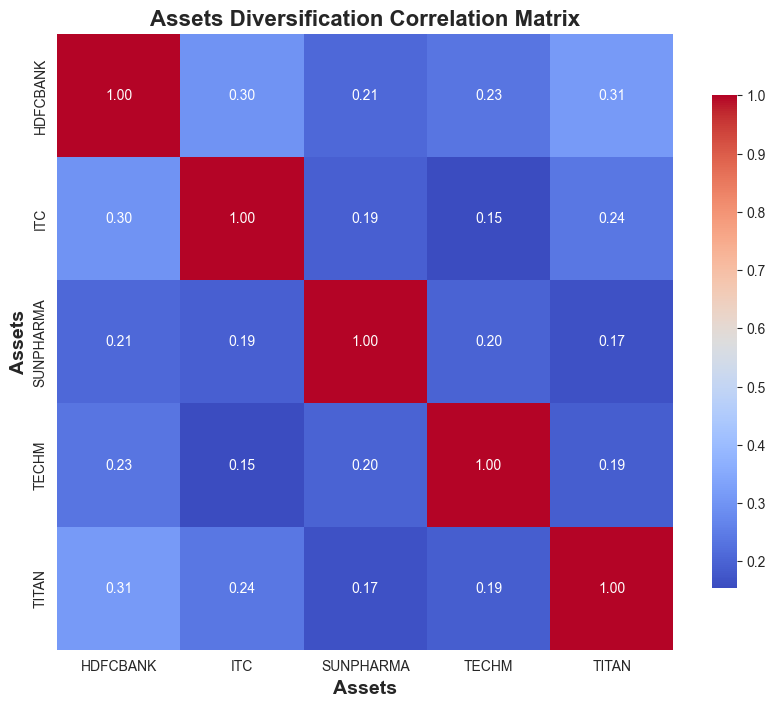

In [422]:
#  plotting the correlation matrix
    # Set a beautiful seaborn style (consistent with previous plots)

os.makedirs('viz_dir/Diversification_Plots', exist_ok=True)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
sns.heatmap(assets_diversification_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.savefig('viz_dir/Diversification_Plots/assets_diversification_correlation_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.xlabel('Assets', fontsize=14, fontweight='bold')
plt.ylabel('Assets', fontsize=14, fontweight='bold')
plt.title('Assets Diversification Correlation Matrix', fontsize=16, fontweight='bold')

# Forecasting

In [630]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox  
from statsmodels.stats.stattools import jarque_bera   
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   
from statsmodels.datasets import get_rdataset
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan



### Data Preperation and initial setup

In [636]:
def forecasting_data_prep(final_df, threshold_date='2019-01-01', dir_path='viz_dir/Forecasting_Plots'):

      os.makedirs(dir_path, exist_ok=True)
      
      forecasting_df = final_df[['Date','Portfolio_Close','Portfolio_Returns']].copy()
      forecasting_df.sort_values('Date', inplace=True)
      forecasting_df = forecasting_df[forecasting_df['Date']>=pd.to_datetime(threshold_date)]
      forecasting_df.set_index('Date', inplace=True)

      train_initial = forecasting_df['Portfolio_Close'][:int(0.8*len(forecasting_df))]
      test = forecasting_df['Portfolio_Close'][int(0.8*len(forecasting_df)):]
      y = forecasting_df['Portfolio_Close']


            # Time Series Plot
      plt.figure(figsize=(12, 6))
      plt.plot(y.index,y)
      plt.savefig(f'{dir_path}/time_series_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
      plt.title('Time Series Plot')
      plt.close()


      return forecasting_df, train_initial, test, y

In [637]:
forecasting_df, train_initial, test, y = forecasting_data_prep(final_df)

In [638]:
# ADF test function
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    return result[1] < 0.05

# Determine d: Difference until stationary
def differencing_the_series(series, d):
          
    y_diff = series.diff(d).dropna() if d > 0 else series
    if adf_test(y_diff):
              return y_diff  # Already stationary
    
    else :
              raise ValueError('Series is not stationary even after differencing.')

y_stationary = differencing_the_series(train_initial, d=2)


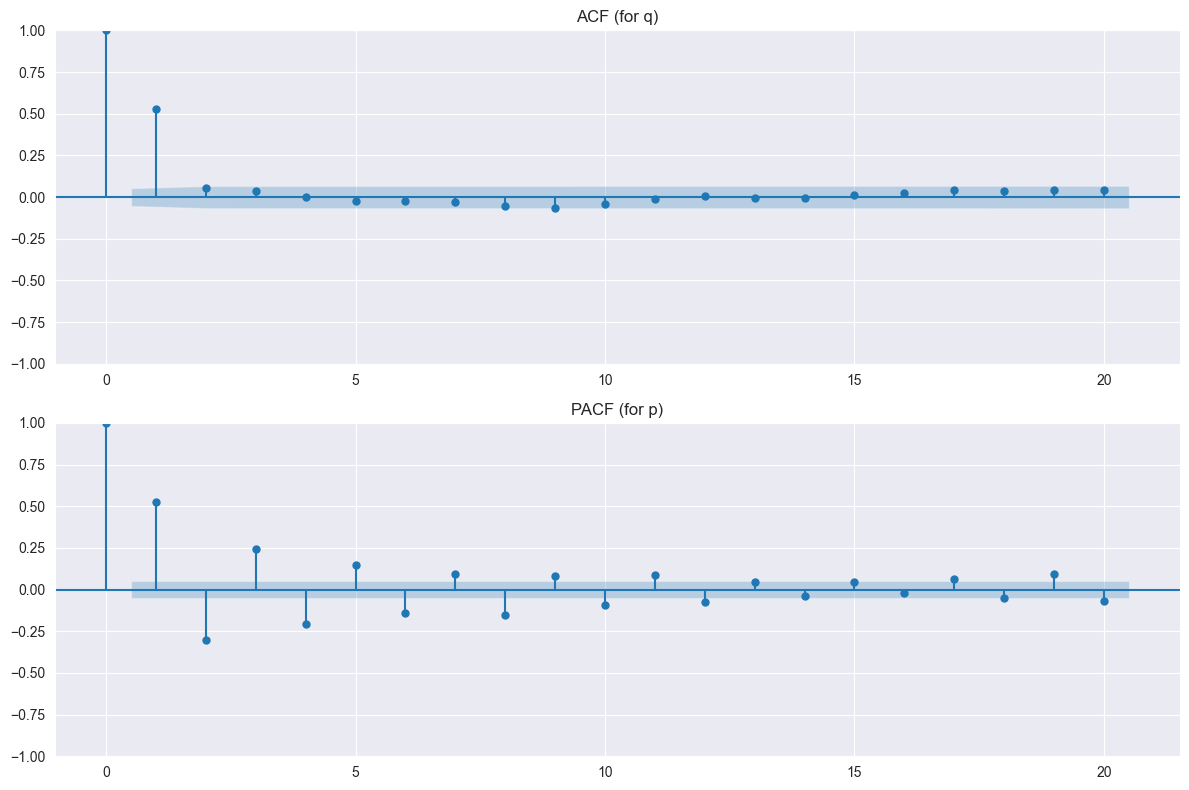

In [639]:
def acf_dcf_analysis(series, lags=20):
          
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series, lags=lags, ax=ax1, title='ACF (for q)')
    plot_pacf(series, lags=lags, ax=ax2, title='PACF (for p)')
    plt.tight_layout()
    plt.savefig('viz_dir/Forecasting_Plots/acf_pacf_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

acf_dcf_analysis(y_stationary)


### Grid Search

In [652]:
# from the acf, pacf plots it is observed that p can be in the range of 0-12 and q can be in the range of 0-1
def grid_search_arima(train_series, p_range, d, q_range):
    best_aic = np.inf
    best_order = (0, d, 0)
    for p in p_range:
        for q in q_range:
            try:
                model_temp = ARIMA(train_series, order=(p, d, q)).fit()
                model_temp.pvalues
                if ((model_temp.pvalues.values).max() < 0.05):  # Ensure all p-values are significant
                    if model_temp.aic < best_aic:
                        best_aic = model_temp.aic
                        best_order = (p, d, q)
            except:
                continue
    return best_order, best_aic

best_order,best_aic = grid_search_arima(train_initial, range(12), 2, range(1))

In [654]:
def walking_forward_model_fitting(train_series, test_series, order, chunk_size=10):
          
    predictions = []
    rolling_train = train_series.copy()  # Starts as initial train

    for i in range(0, len(test_series), chunk_size):
        # Fit on current rolling train
        model = ARIMA(rolling_train, order=order)
        fitted_model = model.fit()
        
        # Multi-step forecast for next chunk
        chunk_pred = fitted_model.forecast(steps=min(chunk_size, len(test_series) - i))
        predictions.extend(chunk_pred.tolist())
        
        # Append next chunk of actual test values to rolling train
        end_idx = min(i + chunk_size, len(test_series))
        next_chunk = test_series.iloc[i:end_idx]
        rolling_train = pd.concat([rolling_train, next_chunk])
        
    # Convert predictions to Series with test index (trim if last chunk partial)
    pred_series = pd.Series(predictions[:len(test_series)], index=test_series.index)
        # Evaluation metrics
    mse = mean_squared_error(test, pred_series)
    mape = np.mean(np.abs((test - pred_series) / test))
    normalized_mse = mse / np.var(test)
    normalized_rmse = np.sqrt(normalized_mse)


    evaluation_results = {}
    evaluation_results['Evaluation_Metrics'] = {
            'MAPE': round(mape,4),
            'Normalized MSE': round(normalized_mse,4),
            'Normalized RMSE': round(normalized_rmse,4)
        }

    evaluation_results_df = pd.DataFrame(evaluation_results)

    
    return pred_series, evaluation_results_df

pred_series, evaluation_results = walking_forward_model_fitting(train_initial, test, best_order, chunk_size=5)

In [659]:

def test_forescasting_plotting(test, pred_series):
          
    plt.figure(figsize=(12, 6))
    # plt.plot(y.index, y, label='Full Data', alpha=0.7)
    plt.plot(test.index, test, label='Actual Test', color='blue')
    plt.plot(test.index, pred_series, label='Walk-Forward Predictions', color='red', linestyle='--')
    plt.title('Walk-Forward ARIMA Forecasts')
    plt.legend()
    save_path='viz_dir/Forecasting_Plots/walk_forward_arima_forecasts.png'
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Walk-Forward ARIMA Forecasts plot saved to {save_path}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    # plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.plot(test.index,test-pred_series, label='Prediction Errors', color='blue')
    plt.title('Prediction Errors Over Time')
    plt.legend()
    save_path='viz_dir/Forecasting_Plots/prediction_errors_over_time.png'
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Prediction Errors Over Time plot saved to {save_path}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    # plt.show()
    plt.close()

test_forescasting_plotting(test, pred_series)

Walk-Forward ARIMA Forecasts plot saved to viz_dir/Forecasting_Plots/walk_forward_arima_forecasts.png
Prediction Errors Over Time plot saved to viz_dir/Forecasting_Plots/prediction_errors_over_time.png


Residuals plots saved to viz_dir/Forecasting_Plots/residuals_plots.png


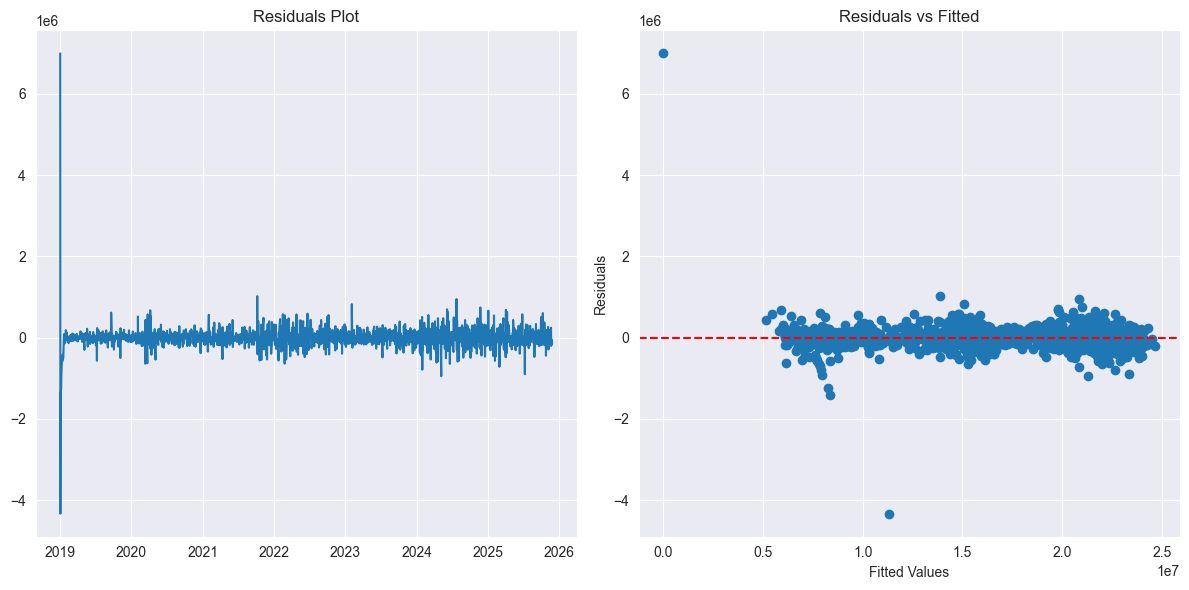

Ljung-Box Test (p-values >0.05 good):
      lb_stat     lb_pvalue
1   87.885034  6.937159e-21
2   88.558824  5.884312e-20
3   88.566086  4.451595e-19
4   88.693376  2.494731e-18
5   88.889783  1.149472e-17
6   89.165951  4.514858e-17
7   89.583291  1.506663e-16
8   90.234933  4.166768e-16
9   91.154853  9.546389e-16
10  92.647358  1.596541e-15
Shapiro-Wilk: Statistic=0.5989, p-value=0.0000 (Normal if >0.05)


In [664]:

def residual_diagnostics(y, save_dir='viz_dir/Forecasting_Plots'):
          # Final model on full data for diagnostics (or use last rolling fit)
    final_model = ARIMA(y, order=best_order).fit()
    residuals = final_model.resid
          
    os.makedirs(save_dir, exist_ok=True)
    

    # 1. Plot residuals (check for patterns/randomness)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(residuals)
    plt.title('Residuals Plot')
    plt.subplot(1, 2, 2)
    plt.scatter(final_model.fittedvalues, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.tight_layout()

    save_path=f'{save_dir}/residuals_plots.png'
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Residuals plots saved to {save_path}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.show()
    plt.close()

    # Ljung-Box test (no autocorrelation: p > 0.05)
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    print('Ljung-Box Test (p-values >0.05 good):')
    print(lb_test)
  
    # Normality: Shapiro-Wilk test (p > 0.05: normal)
    statistic_normal, p_value_normal = stats.shapiro(residuals)
    print(f'Shapiro-Wilk: Statistic={statistic_normal:.4f}, p-value={p_value_normal:.4f} (Normal if >0.05)')
  
  # Stationarity of residuals (ADF: p < 0.05)
    adf_test(residuals, 'Residuals')


residual_diagnostics(y)
    

In [676]:
#  when a grid search is run on all the order values 
# lets build a function that makes a note of how each model is performing based on evaluation metric and residual diagnostics
def comprehensive_arima_evaluation(y,train_series, test_series, p_values, d_values, q_values):
    results = []
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    print(f'Evaluating ARIMA({p},{d},{q})...')
                    order = (p, d, q)
                    model = ARIMA(y, order=order)
                    fitted_model = model.fit()
                    max_pvalue = (fitted_model.pvalues).max()
                    if max_pvalue >= 0.05:
                        print(f'Skipping ARIMA{order} due to high p-value: {max_pvalue}')
                        continue
                    
                    # Walk-forward predictions
                    pred_series, eval_metrics = walking_forward_model_fitting(train_series, test_series, order, chunk_size=5)
                    
                    # Residual diagnostics
                    residuals = fitted_model.resid
                    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
                    lb_pvalue = lb_test['lb_pvalue'].max() # Last lag p-value
                    
                    statistic_normal, p_value_normal = stats.shapiro(residuals)
                    
                    adf_pvalue = adfuller(residuals)[1]
                    
                    results.append({
                        'Order': order,
                        'MAPE': eval_metrics.loc['Evaluation_Metrics', 'MAPE'],
                        'Normalized MSE': eval_metrics.loc['Evaluation_Metrics', 'Normalized MSE'],
                        'Normalized RMSE': eval_metrics.loc['Evaluation_Metrics', 'Normalized RMSE'],
                        'Ljung-Box p-value': lb_pvalue,
                        'Shapiro-Wilk p-value': p_value_normal,
                        'ADF p-value': adf_pvalue
                    })
                except Exception as e:
                    continue
    
    return pd.DataFrame(results)


In [677]:
all_evaluation_results = comprehensive_arima_evaluation(y, train_initial, test, range(12), range(1,3), range(2))

Evaluating ARIMA(0,1,0)...
Evaluating ARIMA(0,1,1)...
Skipping ARIMA(0, 1, 1) due to high p-value: 0.6751128279918768
Evaluating ARIMA(0,2,0)...
Evaluating ARIMA(0,2,1)...
Evaluating ARIMA(1,1,0)...
Skipping ARIMA(1, 1, 0) due to high p-value: 0.6581523987466595
Evaluating ARIMA(1,1,1)...
Skipping ARIMA(1, 1, 1) due to high p-value: 0.17700699795761765
Evaluating ARIMA(1,2,0)...
Evaluating ARIMA(1,2,1)...
Evaluating ARIMA(2,1,0)...
Skipping ARIMA(2, 1, 0) due to high p-value: 0.6740806207021026
Evaluating ARIMA(2,1,1)...
Skipping ARIMA(2, 1, 1) due to high p-value: 0.826602255967838
Evaluating ARIMA(2,2,0)...
Evaluating ARIMA(2,2,1)...
Evaluating ARIMA(3,1,0)...
Skipping ARIMA(3, 1, 0) due to high p-value: 0.722264397308235
Evaluating ARIMA(3,1,1)...
Skipping ARIMA(3, 1, 1) due to high p-value: 0.9985407509200329
Evaluating ARIMA(3,2,0)...
Evaluating ARIMA(3,2,1)...
Skipping ARIMA(3, 2, 1) due to high p-value: 0.11896068817134067
Evaluating ARIMA(4,1,0)...
Skipping ARIMA(4, 1, 0) due t

In [679]:
os.makedirs('Results', exist_ok=True)
all_evaluation_results.to_excel('Results/comprehensive_arima_evaluation_results.xlsx', index=False)